# Network Intrusion Detection

## Importing Libararies

In [3]:
# Importing the required modules
import pandas as pd
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import chi2_contingency
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.metrics import classification_report

from sklearn.metrics import accuracy_score
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score,recall_score,accuracy_score,precision_score
from sklearn.metrics import roc_auc_score,roc_curve,auc
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Input
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras import initializers
from datetime import datetime
from keras.callbacks import EarlyStopping

In [4]:
# reading the csv file
df = pd.read_csv("NetworkIntrusionDetection.csv")
df

,avg_ipt,bytes_in,bytes_out,dest_ip,dest_port,entropy,num_pkts_out,num_pkts_in,proto,src_ip,src_port,time_end,time_start,total_entropy,label,duration
0,229.58333,1359,745,786,22,6.929338,14,14,6,63760,39032,1593951420997637,159395141801898,14579.327000,malicious,2.978657
1,235.00000,0,23,786,2250,3.969002,5,3,6,4837,51307,1593951421585135,1593951421116074,91.287040,malicious,0.469061
2,0.00000,56,56,786,0,1.020244,1,1,1,14618,0,1593951418925389,1593951418925299,114.267365,malicious,0.000090
3,3751.25000,797,22810,786,9200,1.634312,8,6,6,786,41986,1593952043780839,1593952013769036,38581.203000,benign,30.011803
4,64.00000,0,47,786,22222,4.155132,4,3,6,56971,198,1593951423645511,1593951423516886,195.291210,malicious,0.128625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1965381,1434.28580,1685,15511,786,9200,2.572304,14,13,6,786,58360,1593940055183877,1593940035101266,44233.344000,benign,20.082611
1965382,37.00000,344,2155,786,9200,5.719723,2,2,6,786,58358,1593940055184174,1593940055109859,14293.587000,benign,0.074315
1965383,0.00000,0,0,786,27139,0.000000,1,1,6,62355,41107,1593940056538768,1593940056538768,0.000000,malicious,0.000000
1965384,0.00000,0,0,45090,48499,0.000000,2,2,6,786,1829,1593940062726444,159394006223046,0.000000,malicious,0.495984


#### The data contains network events with various attributes.

- avg_ipt: Average inter-packet time.
- bytes_in: Number of incoming bytes.
- bytes_out: Number of outgoing bytes.
- dest_ip: Destination IP address (encoded).
- dest_port: Destination port number.
- entropy: Entropy measurement (possibly of the traffic).
- num_pkts_out: Number of outgoing packets.
- num_pkts_in: Number of incoming packets.
- proto: Network protocol used.
- src_ip: Source IP address (encoded).
- src_port: Source port number.
- time_end: End time of the event.
- time_start: Start time of the event.
- total_entropy: Total entropy.
- label: Classification of the event (e.g., malicious, benign).
- duration: Duration of the event.

In [6]:
df.shape

(1965386, 16)

In [7]:
# getting the info of data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1965386 entries, 0 to 1965385
Data columns (total 16 columns):
 #   Column         Dtype  
---  ------         -----  
 0   avg_ipt        float64
 1   bytes_in       int64  
 2   bytes_out      int64  
 3   dest_ip        int64  
 4   dest_port      int64  
 5   entropy        float64
 6   num_pkts_out   int64  
 7   num_pkts_in    int64  
 8   proto          int64  
 9   src_ip         int64  
 10  src_port       int64  
 11  time_end       int64  
 12  time_start     int64  
 13  total_entropy  float64
 14  label          object 
 15  duration       float64
dtypes: float64(4), int64(11), object(1)
memory usage: 239.9+ MB


In [9]:
# Describing the data to know the mean, median,max, min
df.describe().T

,count,mean,std,min,25%,50%,75%,max
avg_ipt,1965386.0,1.537916e+06,4.435281e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.294967e+09
bytes_in,1965386.0,6.646870e+02,2.947078e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.549800e+04
bytes_out,1965386.0,4.589470e+03,6.382576e+03,0.000000e+00,0.000000e+00,1.004000e+03,8.688000e+03,6.553400e+04
dest_ip,1965386.0,1.619014e+03,9.038564e+03,4.000000e+00,7.860000e+02,7.860000e+02,7.860000e+02,3.965070e+05
dest_port,1965386.0,1.894348e+04,1.973066e+04,0.000000e+00,9.200000e+03,9.200000e+03,5.073400e+04,6.553400e+04
entropy,1965386.0,2.792449e+00,2.191571e+00,0.000000e+00,1.020244e+00,2.513993e+00,4.611140e+00,1.351081e+02
num_pkts_out,1965386.0,5.284574e+00,1.152795e+01,0.000000e+00,1.000000e+00,3.000000e+00,7.000000e+00,2.550000e+02
num_pkts_in,1965386.0,2.072409e+00,8.505669e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,2.550000e+02
proto,1965386.0,6.608359e+00,2.694902e+00,1.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,5.800000e+01
src_ip,1965386.0,8.551891e+03,2.944796e+04,3.000000e+00,7.860000e+02,7.860000e+02,7.860000e+02,3.976510e+05


In [11]:
#checking for null values
df.isnull().sum()

avg_ipt          0
bytes_in         0
bytes_out        0
dest_ip          0
dest_port        0
entropy          0
num_pkts_out     0
num_pkts_in      0
proto            0
src_ip           0
src_port         0
time_end         0
time_start       0
total_entropy    0
label            0
duration         0
dtype: int64

## EDA

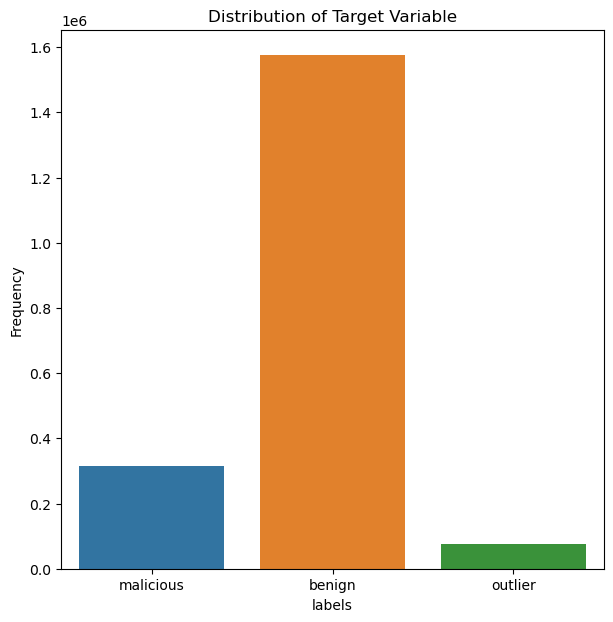

In [17]:
# Checking the distribution of target variable
plt.figure(figsize=(7,7))
sns.countplot(x='label', data = df)
plt.title('Distribution of Target Variable')
plt.xlabel('labels')
plt.ylabel('Frequency')
plt.show()

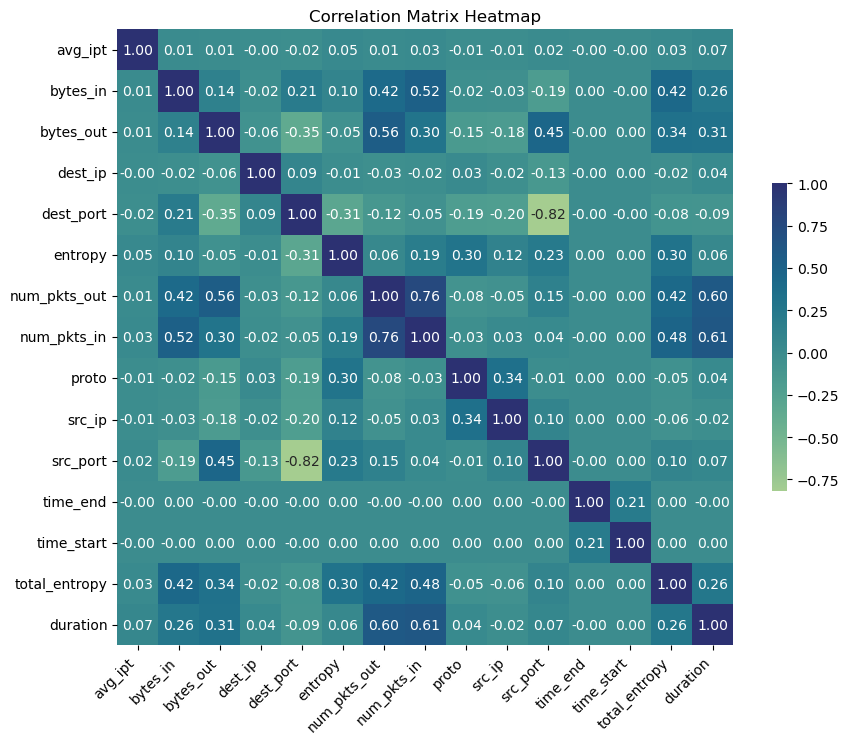

In [16]:
# Calculating the correlation matrix and Creating a heatmap to visualize it
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap="crest", fmt=".2f", square=True, cbar_kws={"shrink": .5})

# Adjust the layout
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.title('Correlation Matrix Heatmap')

# Show the plot
plt.show()

In [18]:
# checking the values in each labels
df['label'].value_counts()

benign       1574580
malicious     315227
outlier        75579
Name: label, dtype: int64

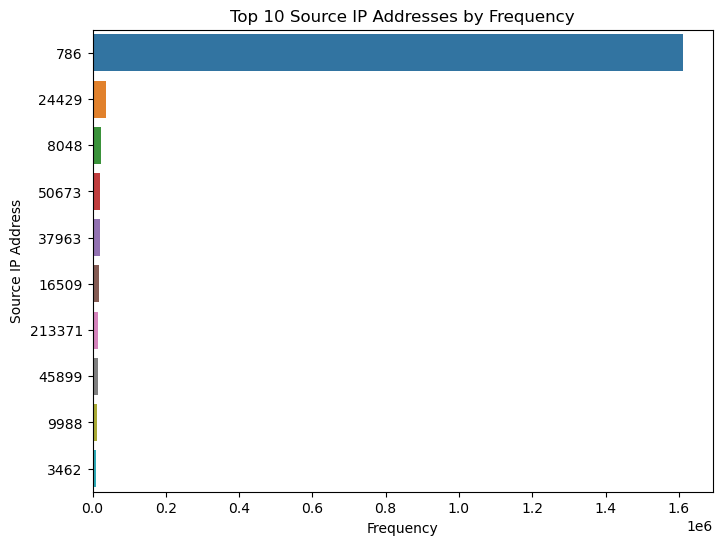

In [19]:
# Plotting the distribution of source IP addresses
plt.figure(figsize=(8, 6))
sns.countplot(y='src_ip', data=df, order = df['src_ip'].value_counts().iloc[:10].index)
plt.title('Top 10 Source IP Addresses by Frequency')
plt.xlabel('Frequency')
plt.ylabel('Source IP Address')
plt.show()

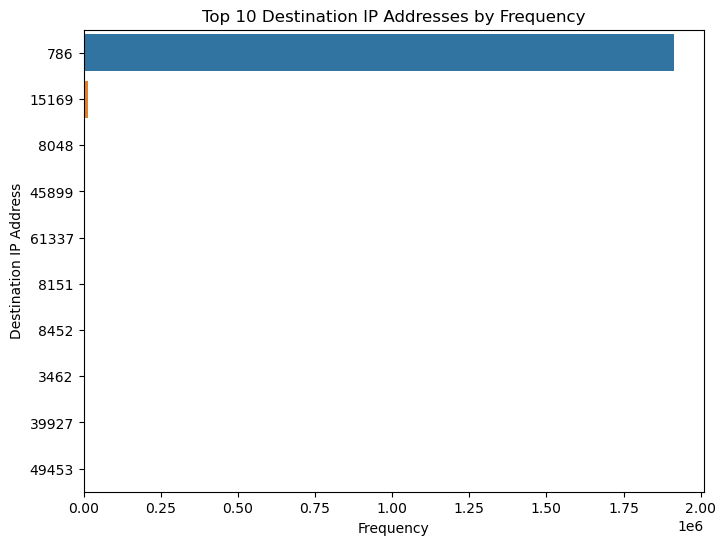

In [20]:
# Plotting the distribution of destination IP addresses
plt.figure(figsize=(8, 6))
sns.countplot(y='dest_ip', data=df, order = df['dest_ip'].value_counts().iloc[:10].index)
plt.title('Top 10 Destination IP Addresses by Frequency')
plt.xlabel('Frequency')
plt.ylabel('Destination IP Address')
plt.show()

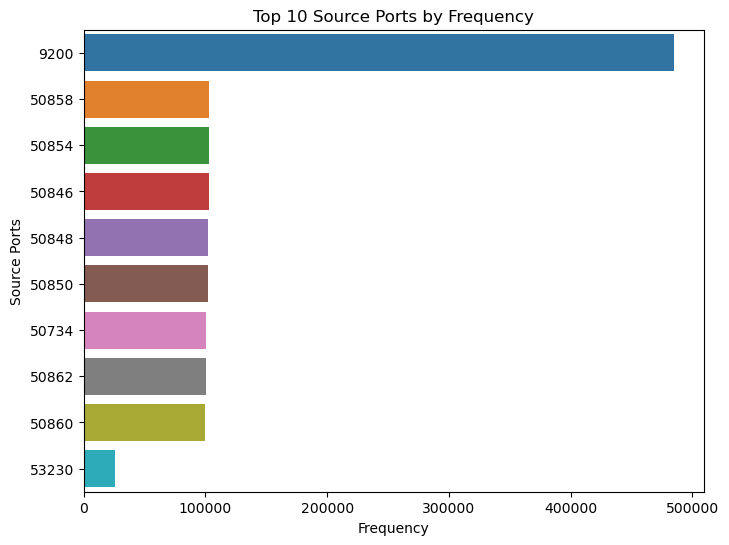

In [21]:
# Plotting the distribution of destination IP addresses
plt.figure(figsize=(8, 6))
sns.countplot(y='src_port', data=df, order = df['src_port'].value_counts().iloc[:10].index)
plt.title('Top 10 Source Ports by Frequency')
plt.xlabel('Frequency')
plt.ylabel('Source Ports')
plt.show()

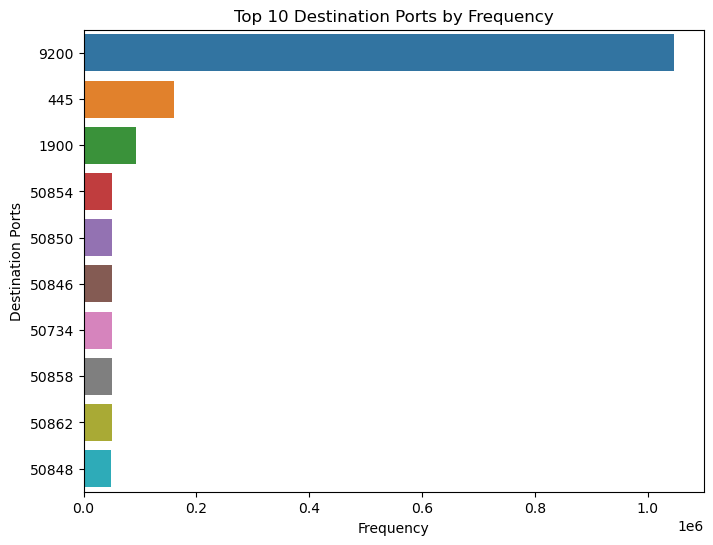

In [22]:
# Plotting the distribution of destination IP addresses
plt.figure(figsize=(8, 6))
sns.countplot(y='dest_port', data=df, order = df['dest_port'].value_counts().iloc[:10].index)
plt.title('Top 10 Destination Ports by Frequency')
plt.xlabel('Frequency')
plt.ylabel('Destination Ports')
plt.show()

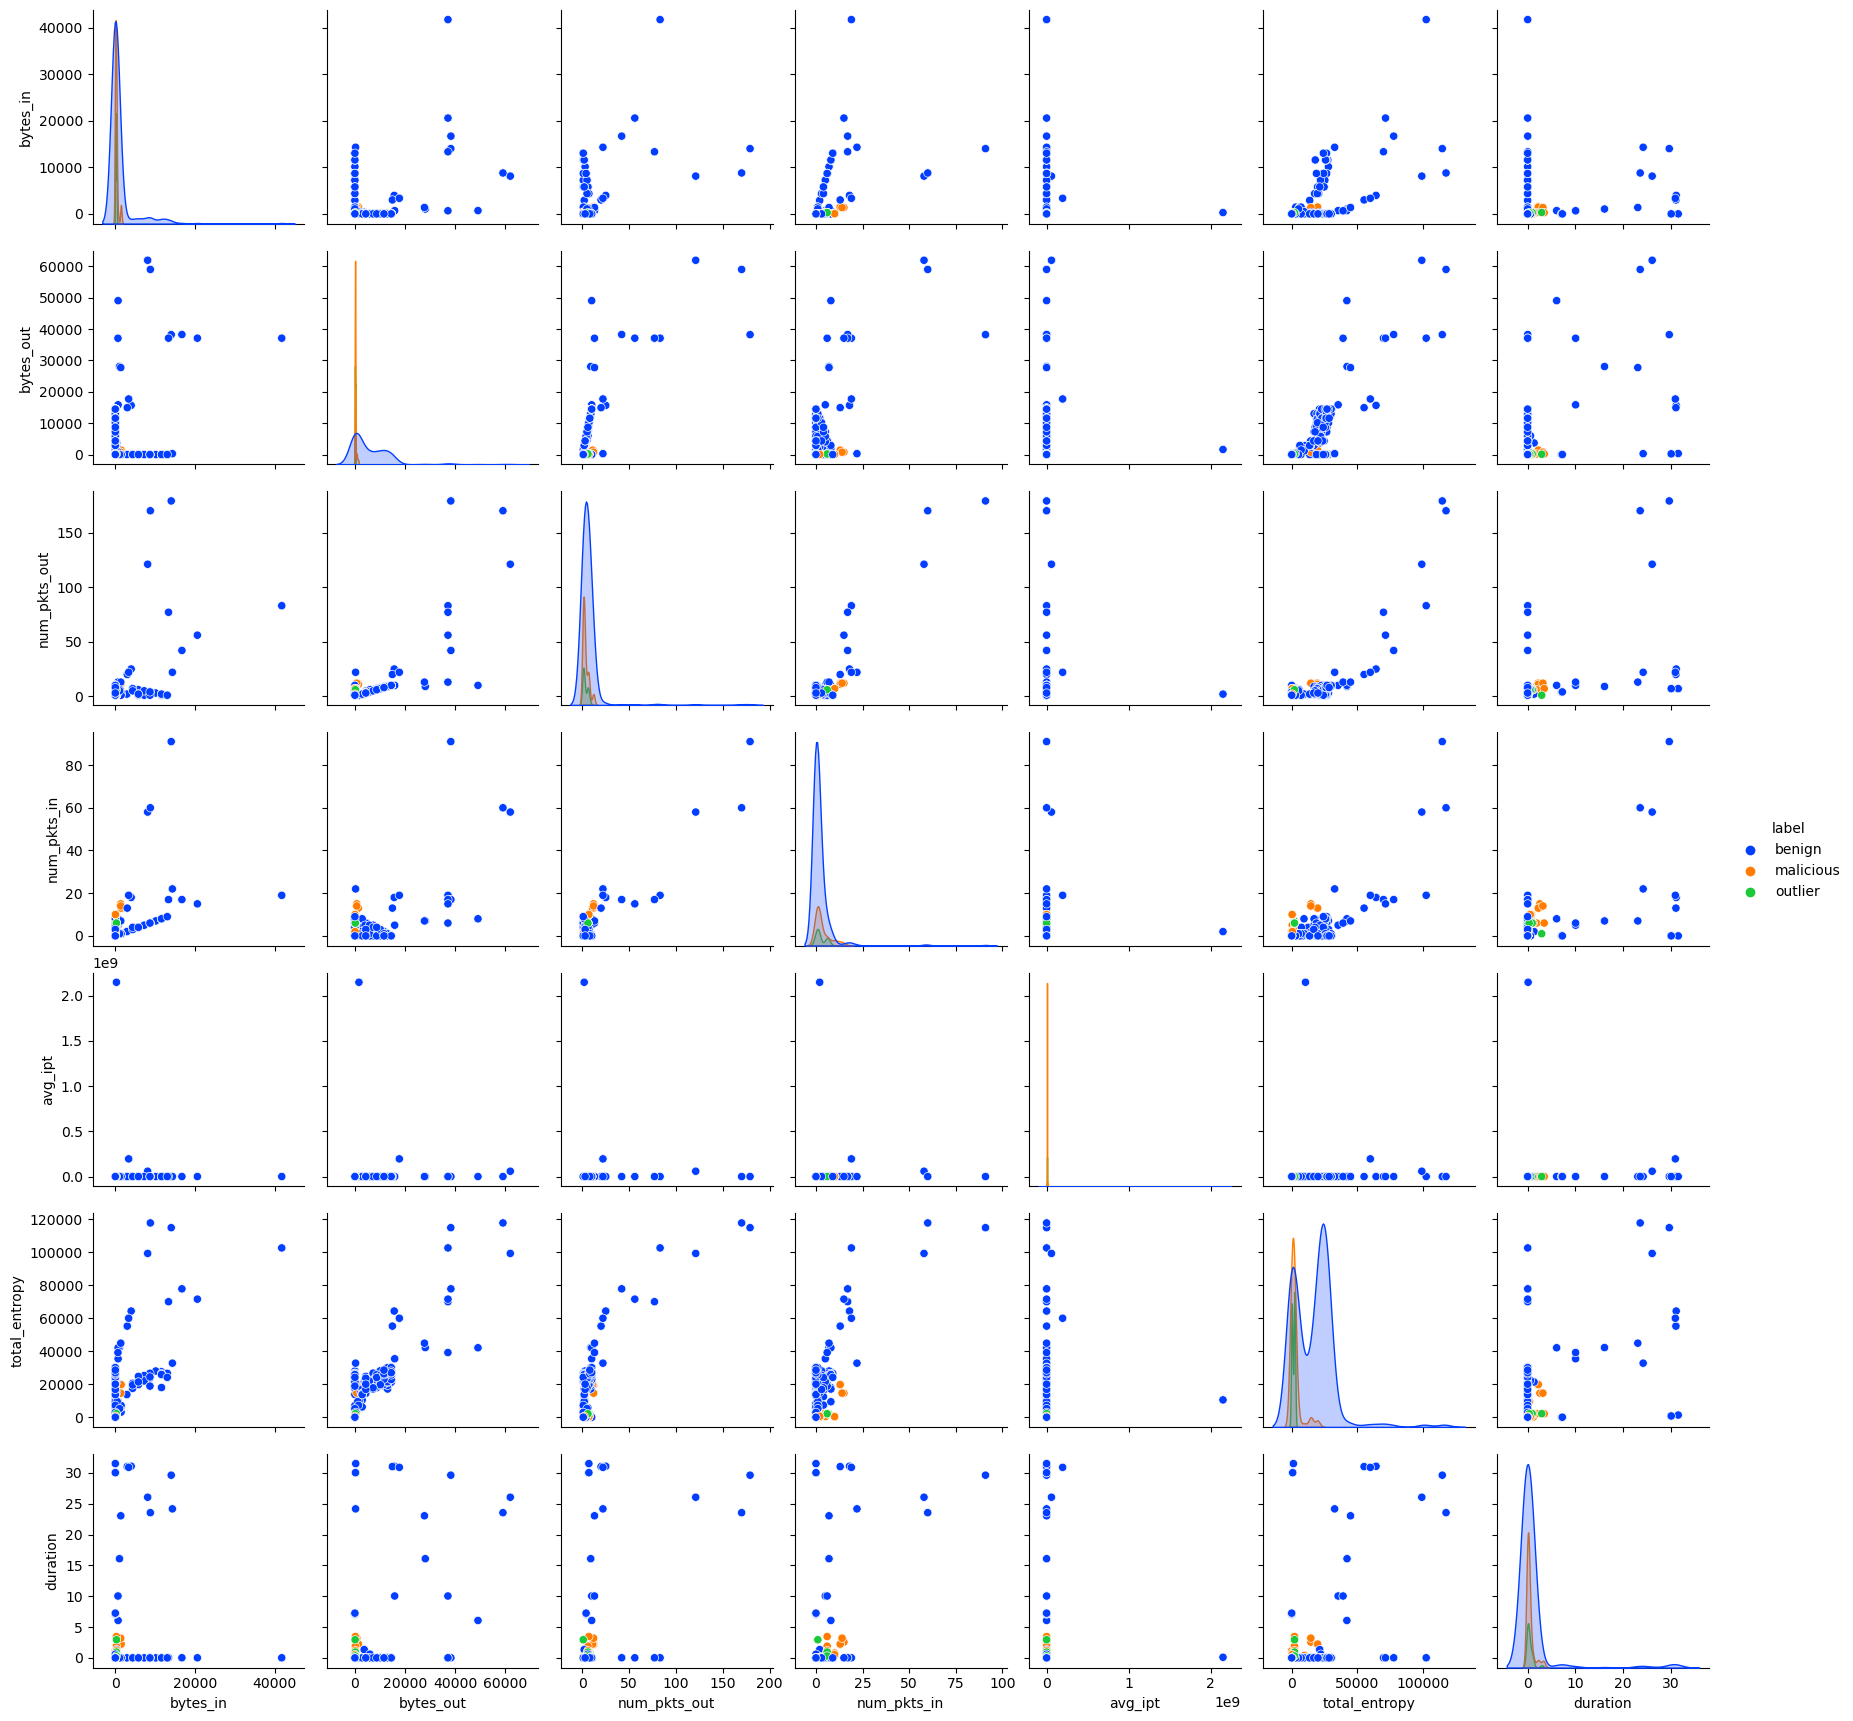

In [23]:
# Selecting a subset of variables to plot
variables_to_plot = ['bytes_in', 'bytes_out', 'num_pkts_out','num_pkts_in', 'avg_ipt', 'total_entropy', 'duration']

sampled_data = df[variables_to_plot].sample(n=500, random_state=42)

# Adding the 'label' column for color coding
sampled_data['label'] = df['label'].sample(n=500, random_state=42)

# Creating the pairplot
sns.pairplot(sampled_data, hue='label', palette='bright')
plt.show()

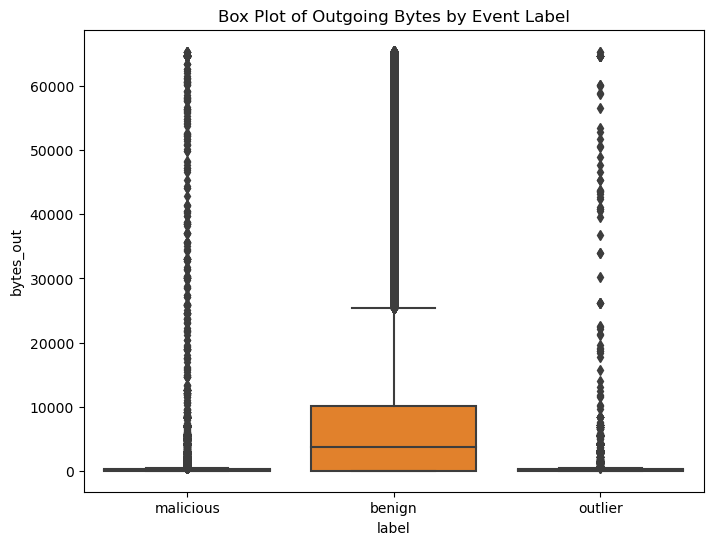

In [24]:
# Box plot for 'bytes_out' segmented by 'label'
plt.figure(figsize=(8, 6))
sns.boxplot(x='label', y='bytes_out', data=df)
plt.title('Box Plot of Outgoing Bytes by Event Label')
plt.show()

## One Hot encoding

In [25]:
# applying one hot encoding for target variable
encoded_data = pd.get_dummies(df, columns = ['label']) 
encoded_data

,avg_ipt,bytes_in,bytes_out,dest_ip,dest_port,entropy,num_pkts_out,num_pkts_in,proto,src_ip,src_port,time_end,time_start,total_entropy,duration,label_benign,label_malicious,label_outlier
0,229.58333,1359,745,786,22,6.929338,14,14,6,63760,39032,1593951420997637,159395141801898,14579.327000,2.978657,0,1,0
1,235.00000,0,23,786,2250,3.969002,5,3,6,4837,51307,1593951421585135,1593951421116074,91.287040,0.469061,0,1,0
2,0.00000,56,56,786,0,1.020244,1,1,1,14618,0,1593951418925389,1593951418925299,114.267365,0.000090,0,1,0
3,3751.25000,797,22810,786,9200,1.634312,8,6,6,786,41986,1593952043780839,1593952013769036,38581.203000,30.011803,1,0,0
4,64.00000,0,47,786,22222,4.155132,4,3,6,56971,198,1593951423645511,1593951423516886,195.291210,0.128625,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1965381,1434.28580,1685,15511,786,9200,2.572304,14,13,6,786,58360,1593940055183877,1593940035101266,44233.344000,20.082611,1,0,0
1965382,37.00000,344,2155,786,9200,5.719723,2,2,6,786,58358,1593940055184174,1593940055109859,14293.587000,0.074315,1,0,0
1965383,0.00000,0,0,786,27139,0.000000,1,1,6,62355,41107,1593940056538768,1593940056538768,0.000000,0.000000,0,1,0
1965384,0.00000,0,0,45090,48499,0.000000,2,2,6,786,1829,1593940062726444,159394006223046,0.000000,0.495984,0,1,0


## Train test Split

In [26]:
# separating the tareget variable
X = encoded_data.drop(['label_malicious', 'label_benign', 'label_outlier',], axis=1)
Y = encoded_data[['label_malicious', 'label_benign', 'label_outlier']]

In [27]:
#Checking the x variable data
X

,avg_ipt,bytes_in,bytes_out,dest_ip,dest_port,entropy,num_pkts_out,num_pkts_in,proto,src_ip,src_port,time_end,time_start,total_entropy,duration
0,229.58333,1359,745,786,22,6.929338,14,14,6,63760,39032,1593951420997637,159395141801898,14579.327000,2.978657
1,235.00000,0,23,786,2250,3.969002,5,3,6,4837,51307,1593951421585135,1593951421116074,91.287040,0.469061
2,0.00000,56,56,786,0,1.020244,1,1,1,14618,0,1593951418925389,1593951418925299,114.267365,0.000090
3,3751.25000,797,22810,786,9200,1.634312,8,6,6,786,41986,1593952043780839,1593952013769036,38581.203000,30.011803
4,64.00000,0,47,786,22222,4.155132,4,3,6,56971,198,1593951423645511,1593951423516886,195.291210,0.128625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1965381,1434.28580,1685,15511,786,9200,2.572304,14,13,6,786,58360,1593940055183877,1593940035101266,44233.344000,20.082611
1965382,37.00000,344,2155,786,9200,5.719723,2,2,6,786,58358,1593940055184174,1593940055109859,14293.587000,0.074315
1965383,0.00000,0,0,786,27139,0.000000,1,1,6,62355,41107,1593940056538768,1593940056538768,0.000000,0.000000
1965384,0.00000,0,0,45090,48499,0.000000,2,2,6,786,1829,1593940062726444,159394006223046,0.000000,0.495984


In [28]:
#Checking the y variable data
Y

,label_malicious,label_benign,label_outlier
0,1,0,0
1,1,0,0
2,1,0,0
3,0,1,0
4,1,0,0
...,...,...,...
1965381,0,1,0
1965382,0,1,0
1965383,1,0,0
1965384,1,0,0


In [29]:
# splitting the data into train and test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

## Undersampling

In [30]:
#performoing undersampling randomly

#combining the x train and y trains
df1_combine = pd.concat([pd.DataFrame(X_train), pd.DataFrame(Y_train, columns=['label_malicious', 'label_benign', 'label_outlier'])], axis=1)

#seperating all classes
c0 = df1_combine[df1_combine['label_malicious']==1]
c1 = df1_combine[df1_combine['label_benign']==1]
c2 = df1_combine[df1_combine['label_outlier']==1]

#performing undersamplling for each class
un_c0 = resample(c0, replace=True, n_samples=60000,random_state=42)
un_c1 = resample(c1, replace=True, n_samples=60000,random_state=42)
un_c2 = resample(c2, replace=True, n_samples=60000,random_state=42)

print(un_c0.shape)
print(un_c1.shape)
print(un_c2.shape)

#combining the undersample data of each class
un_df1 = pd.concat([un_c0, un_c1, un_c2])

#performing the shuffeling of data to apply the randomness in each class for whole data
un_df1 = un_df1.sample(frac=1, random_state=42)

#Seperating the x-train and y-train again to use in train test split
x_un_train = un_df1.iloc[:,:-3]
y_un_train = un_df1.iloc[:,-3:]

(60000, 18)
(60000, 18)
(60000, 18)


In [31]:
#chekcing the shape of training dataset
print("Shape of x: ",x_un_train.shape)
print("Shape of y: ",y_un_train.shape)

Shape of x:  (180000, 15)
Shape of y:  (180000, 3)


In [32]:
# performing scalling
scaler = StandardScaler()
x_un_train = scaler.fit_transform(x_un_train)

## DNN Model

In [33]:
#Building a DNN model

#implementing He initializers
ini1 = initializers.HeNormal()
ini2 = initializers.HeNormal()
ini3 = initializers.HeNormal()
ini4 = initializers.HeNormal()
ini5 = initializers.HeNormal()
ini6 = initializers.HeNormal()

def create_model():
    model = Sequential()
    model.add(Dense(512, input_dim=x_un_train.shape[1], activation='relu', kernel_initializer = ini1))
    model.add(Dropout(0.45))
    model.add(Dense(256, activation='relu', kernel_initializer = ini2))
    model.add(Dropout(0.45))
    model.add(Dense(128, activation='relu', kernel_initializer = ini3))
    model.add(Dropout(0.45))
    model.add(Dense(64, activation='relu', kernel_initializer = ini4))
    model.add(Dropout(0.45))
    model.add(Dense(32, activation='relu', kernel_initializer = ini5))
    model.add(Dropout(0.45))
    model.add(Dense(16, activation='relu', kernel_initializer = ini6))
    model.add(Dropout(0.45))
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

#adding early stopping
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model = create_model()

In [34]:
#Training the model
model.fit(x_un_train, y_un_train, epochs=8, batch_size=800, validation_data=(X_test, Y_test), callbacks=[es])

# Evaluate the model on the test set
y_prd = (model.predict(X_test) > 0.5).astype("int32")
accuracy = accuracy_score(Y_test, y_prd)
print(f"Accuracy on the test set: {accuracy}")

Epoch 1/8


225/225 [==============================] - 7s 26ms/step - loss: 1.1456 - accuracy: 0.4266 - val_loss: 63012815765504.0000 - val_accuracy: 0.6918
Epoch 2/8
225/225 [==============================] - 7s 30ms/step - loss: 0.6829 - accuracy: 0.6241 - val_loss: 641912524505088.0000 - val_accuracy: 0.0388
Epoch 3/8
225/225 [==============================] - 6s 29ms/step - loss: 0.5763 - accuracy: 0.6615 - val_loss: 644571914567680.0000 - val_accuracy: 0.0388
Epoch 4/8
225/225 [==============================] - 7s 30ms/step - loss: 0.5457 - accuracy: 0.6806 - val_loss: 637099275452416.0000 - val_accuracy: 0.0388
Epoch 5/8
225/225 [==============================] - 7s 29ms/step - loss: 0.5236 - accuracy: 0.6963 - val_loss: 29115012874240.0000 - val_accuracy: 0.0929
Epoch 6/8
225/225 [==============================] - 7s 30ms/step - loss: 0.5067 - accuracy: 0.7138 - val_loss: 62313998581760.0000 - val_accuracy: 0.0388
Epoch 7/8
225/225 [==============================] - 6s 26ms/step

## Classification report

In [35]:
# Generate the classification report
report = classification_report(Y_test, y_prd)

# Print the classification report
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00     62931
           1       0.00      0.00      0.00    314903
           2       0.04      1.00      0.07     15244

   micro avg       0.04      0.04      0.04    393078
   macro avg       0.01      0.33      0.02    393078
weighted avg       0.00      0.04      0.00    393078
 samples avg       0.04      0.04      0.04    393078



## Random Forest Model

In [41]:
# import Random Forest classifier

from sklearn.ensemble import RandomForestClassifier
# instantiate the classifier 
rfc = RandomForestClassifier(random_state=0)

# fit the model
rfc.fit(x_un_train, y_un_train)

# Predict the Test set results
y_pred = rfc.predict(X_test)

# Check accuracy score 
from sklearn.metrics import accuracy_score
print('Model accuracy score with 10 decision-trees : {0:0.4f}'. format(accuracy_score(Y_test, y_pred)))

Model accuracy score with 10 decision-trees : 0.0342


In [45]:
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.13      0.21      0.16     62931
           1       0.00      0.00      0.00    314903
           2       0.00      0.00      0.00     15244

   micro avg       0.13      0.03      0.05    393078
   macro avg       0.04      0.07      0.05    393078
weighted avg       0.02      0.03      0.03    393078
 samples avg       0.03      0.03      0.03    393078

